# ECAL PhiSym on NanoAOD with awkward+coffea

In [1]:
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory
from ecalphisym import EcalPhiSymSchema

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.style.use('seaborn-white')

In [24]:
from coffea.processor import AccumulatorABC, ProcessorABC, Runner, FuturesExecutor

class EcalPhiSymAccumulator(AccumulatorABC):
    def __init__(self, ebhits=None, eehits=None, info=None):
        self._ebhits = ebhits
        self._eehits = eehits
        self._info = info
        
    def add(self, other):
        if self._ebhits is not None or self._eehits is not None or self._info is not None:
            self._ebhits = ak.concatenate([self._ebhits, other._ebhits], behavior=self._ebhits.behavior)
            self._eehits = ak.concatenate([self._eehits, other._eehits], behavior=self._eehits.behavior)
            self._info = ak.concatenate([self._info, other._info], behavior=self._info.behavior)  
        else:
            self._ebhits = other._ebhits
            self._eehits = other._eehits
            self._info = other._info            
            
    def identity(self):
        return EcalPhiSymAccumulator()
    
    @property
    def ebhits(self):
        """Return the ebhits array"""
        return self._ebhits

    @property
    def eehits(self):
        """Return the eehits array"""
        return self._eehits
    
    @property
    def info(self):
        """Return the info array"""
        return self._info
    

In [25]:
class Processor(ProcessorABC):   
    def process(self, runs):
        counts = np.unique(runs.EcalPhiSymInfo.fill, return_index=True)[1]
        splits = np.diff(np.concatenate([counts, [len(runs.EcalPhiSymInfo.fill)]]))
        info = ak.unflatten(runs.EcalPhiSymInfo, splits, axis=0, behavior=runs.behavior).sum(axis=1)
        ebhits = ak.unflatten(runs.EcalPhiSymEB, splits, axis=0, behavior=runs.behavior).sum(axis=1)
        eehits = ak.unflatten(runs.EcalPhiSymEE, splits, axis=0, behavior=runs.behavior).sum(axis=1)
        return EcalPhiSymAccumulator(ebhits=ebhits, eehits=eehits, info=info)
    
    def postprocess(self, accumulator):
        return accumulator

In [26]:
from ecalautoctrl import RunCtrl

rctrl = RunCtrl(dbname='ecal_prompt_v1', campaign='prompt')
fileset = {'PhiSym' : ['root://eoscms.cern.ch/'+f for f in rctrl.getOutput(era='Run2022E', process='phisym-reco')]}

In [28]:
iterative_run = Runner(
    executor = FuturesExecutor(compression=None, workers=4),
    schema=EcalPhiSymSchema
)
out = iterative_run(
    fileset,
    treename="Runs",
    processor_instance=Processor(),
)
out

     Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113/113 [ 0:00:37 < 0:00:00 | 2.9  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113/113 [ 0:00:37 < 0:00:00 | ?   merges/s ]
     Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113/113 [ 0:00:37 < 0:00:00 | 2.9  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113/113 [ 0:00:37 < 0:00:00 | ?   merges/s ]

In [29]:
fills = ak.flatten(out.info.fill)
idx = ak.argsort(fills)
counts = np.unique(fills[idx], return_index=True)[1]
splits = np.diff(np.concatenate([counts, [len(fills)]]))

In [30]:
info = ak.unflatten(out.info[idx], splits, axis=0, behavior=out.info.behavior).sum(axis=1)
ebhits = ak.unflatten(out.ebhits[idx], splits, axis=0, behavior=out.ebhits.behavior).sum(axis=1)
eehits = ak.unflatten(out.eehits[idx], splits, axis=0, behavior=out.eehits.behavior).sum(axis=1)

In [31]:
k = ak.linear_fit(info.miscalibs_eb, ebhits.sumet_v, axis=2)

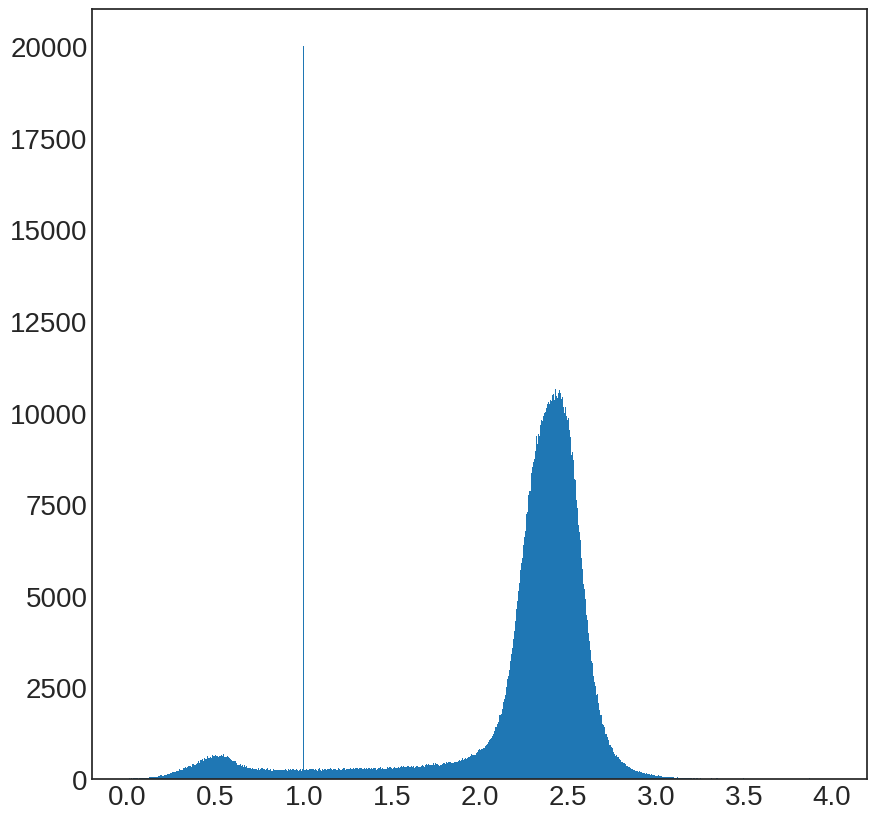

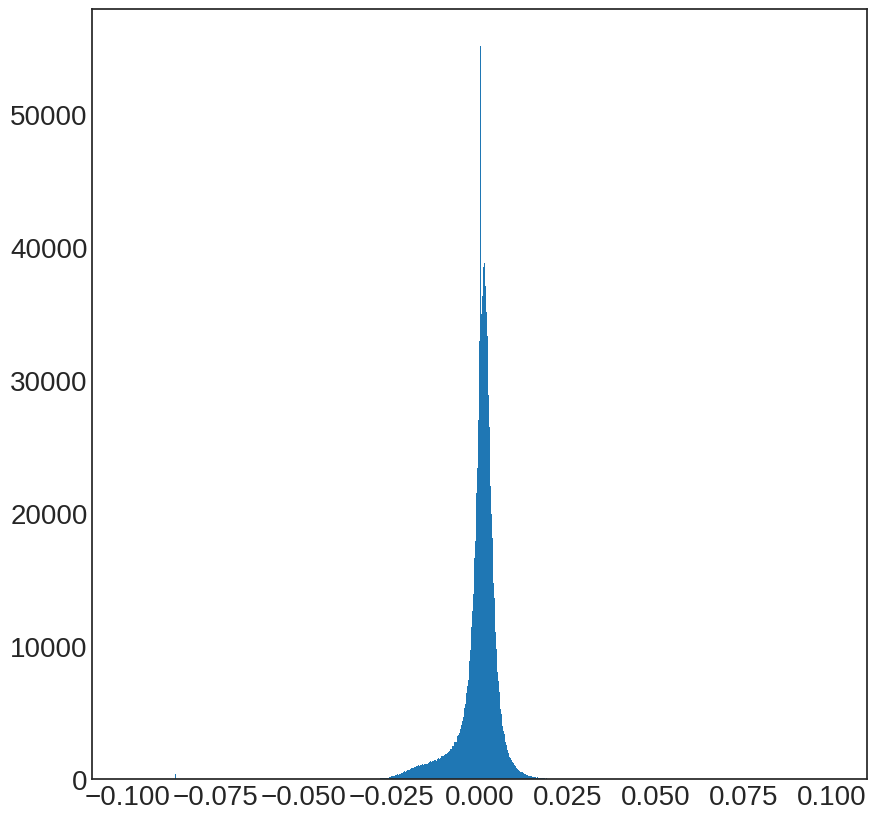

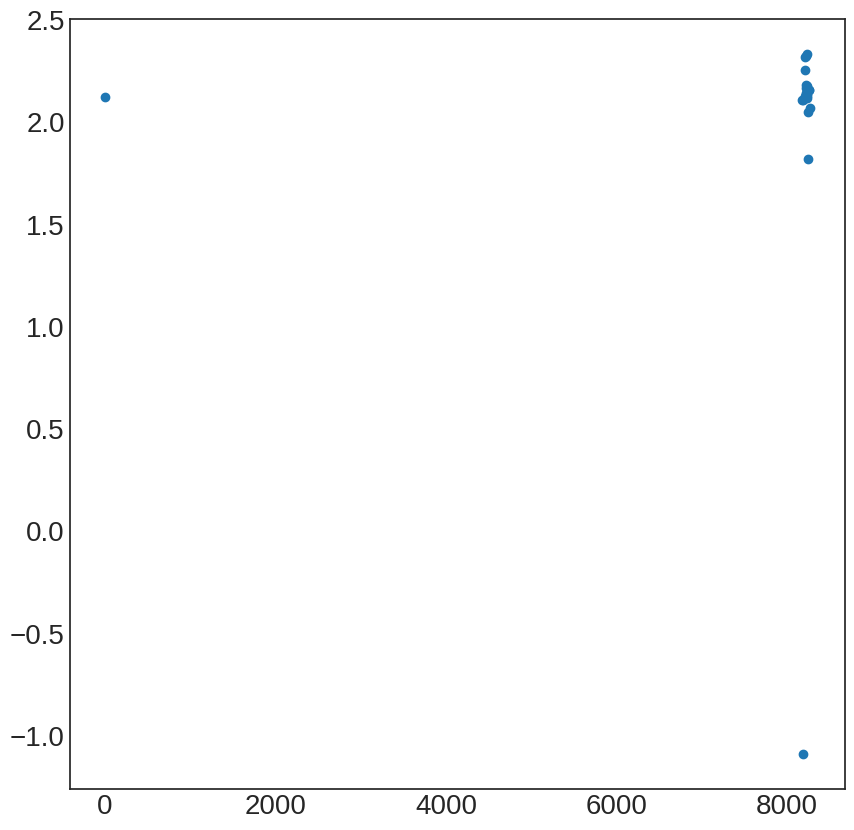

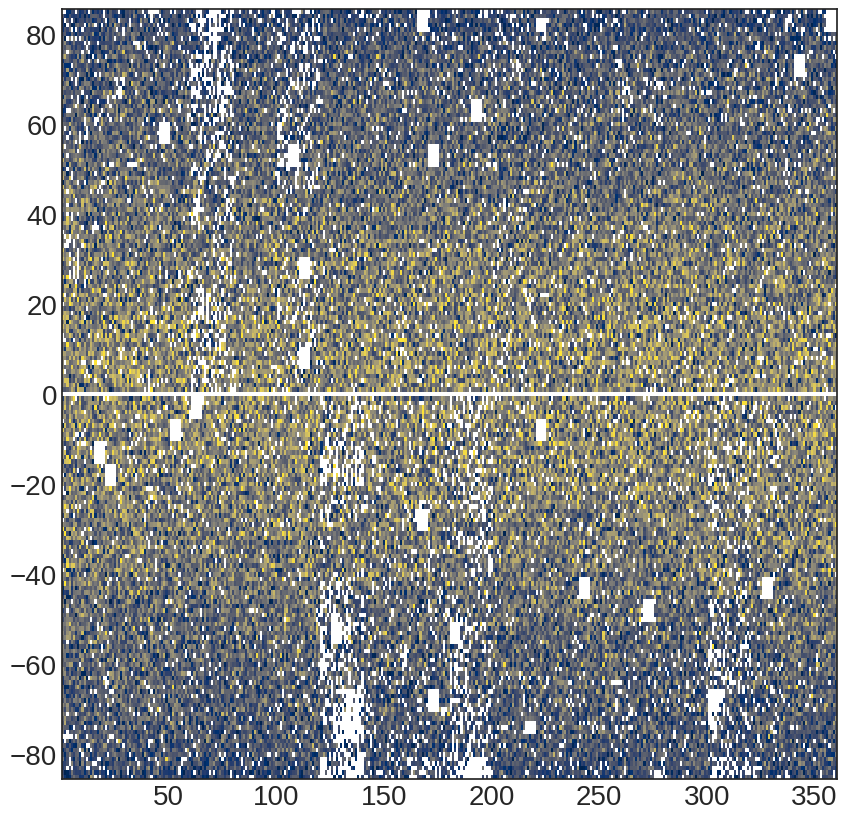

In [32]:
plt.hist(ak.flatten(k.slope), bins=1000, range=[0,4])
plt.show()
plt.hist(ak.flatten(k.intercept), bins=1000, range=[-0.1, 0.1])
plt.show()
plt.scatter(info.fill, k.slope[:,100])
plt.show()
plt.hist2d(ak.to_numpy(ebhits.iphi[1,:]), ak.to_numpy(ebhits.ieta[1,:]), weights=ak.to_numpy(k.slope[1]), 
           bins=[360, 171], range=[[0.5,360.5], [-85.5, 85.5]], 
           cmap='cividis', cmin=2, cmax=3)
plt.show()

In [33]:
def boundaryCrystals(data):
    """
    Flag crystals on module boundaries:
    - first and last crystals in a SM along phi (iphi % 20 == 0|1)
    - first and last crystals in a module along eta (|ieta| = 1, 25,26, 45,46, 65,66, 85)
    """

    bounds = ak.zeros_like(data.ieta)
    for idx in [1, 25, 25, 45, 46, 65, 66, 85]:
        bounds = bounds + (abs(data.ieta) == idx)
        
    return (data.iphi % 20 == 0) | (data.iphi % 20 == 1) | (bounds > 0)

In [34]:
sumEtEB = ak.sum(ak.mask(ebhits.sumet, boundaryCrystals(ebhits), valid_when=False), axis=1)

In [35]:
norm = ak.Array(np.repeat([ebhits.sumet[1]/sumEtEB[1]], len(ebhits.sumet), axis=0))
eflow = (((ebhits.sumet/sumEtEB)/norm)-1)/k.slope+1

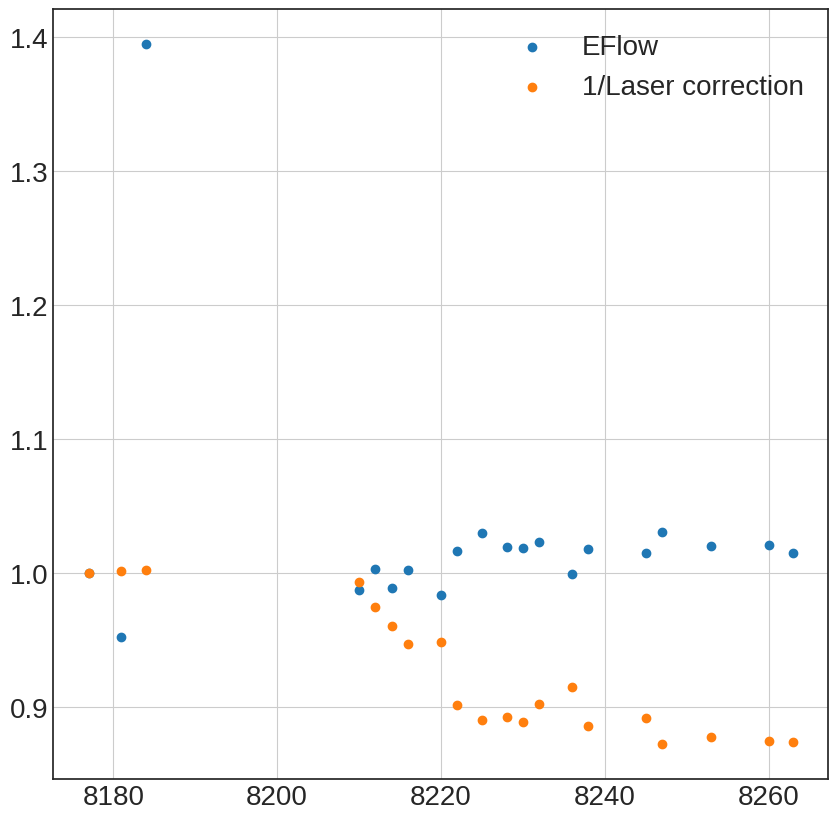

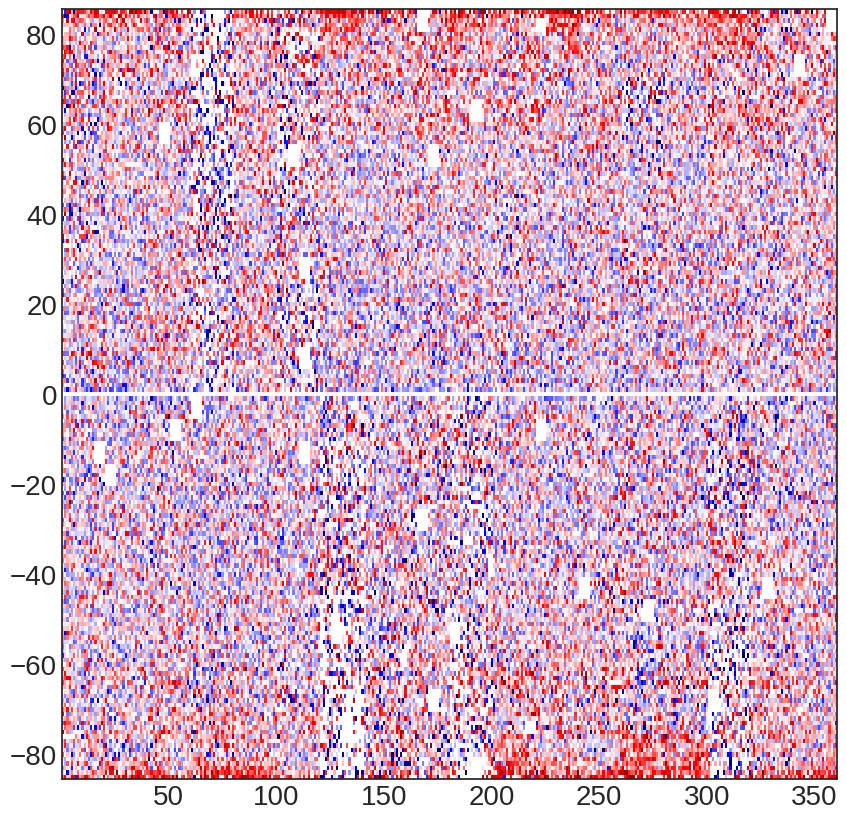

In [37]:
icry=500
plt.scatter(info.fill[1:], eflow[1:,icry], label='EFlow')
plt.scatter(info.fill[1:], (ebhits.sumlc[1,icry]/ebhits.nhits[1,icry])/(ebhits.sumlc[1:,icry]/ebhits.nhits[1:,icry]), 
            label='1/Laser correction')
plt.legend()
plt.grid()
plt.show()
# plot the map of the last iov
plt.hist2d(ak.to_numpy(ebhits.iphi[-1,:]), ak.to_numpy(ebhits.ieta[-1,:]), weights=ak.to_numpy(eflow[-1]), 
           bins=[360, 171], range=[[0.5,360.5], [-85.5, 85.5]], 
           cmap='seismic', cmin=0.9, cmax=1.1)
plt.show()